## A node-based layered graph approach for the Steiner tree problem with revenues, budget and hop-constraints


### Node-based layered graph

Let $H > 0$ be the hop limit:

### Variables

$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node $j$ is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$
y^h_j = \begin{cases} 1 \text{ if node $j$ is on layer $h$ in the arborescence}\\
0 \text{ otherwise}
\end{cases}  \forall j \in V \setminus\{0\}
$$
### The Model
$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
\sum_{(i,j)\in \delta^+(S) } x_{ij}& \ge y_k \;\; \forall S \subset V, 0 \in S, k \in V\setminus S\\
\sum_{h = 1}^H y_j^h&  = y_j  \;\; \forall j \in V \setminus\{0\} \\
x_{0j} &= y^1_j \;\; \forall j \in \delta^+(0) \\
y_i^{h-1} + x_{ij} & \le 1 + y_j^h \;\; \forall (i,j) \in A, j \not= \{0\}, h \in \{2,\ldots,H\} \\
y_i^H + x_{ij} & \le 1 \;\; \forall (i,j) \in A, j \not = \{0\}\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V \\
y^h_j & \in \{0,1\} \;\; \forall j \in V,  1 \le h \le H \\
\end{align}
$$

#### Theorem

Constraints 
$$
\sum_{(i,j)\in \delta^+(S) } x_{ij} \ge y_k \;\; \forall S \subset V, 0 \in S, k \in V\setminus S
$$
can be substituted by: 
$$
x_{ij} + x_{ji} \le y_j \;\; \forall i,j \in V
$$

In [1]:
import networkx as nx
import gurobipy as gb
#import pygraphviz as pygv
import argparse
from argparse import ArgumentTypeError
#import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [ ]:
#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()

def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        elif y[i].x > 0.99999:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="gray", fontsize='8', width='0.3', fixedsize='true')

    for i in D.edges():
        if x[i].x > 0.999999:
            DrawG.add_edge(i[0], i[1], color='black')

    DrawG.layout(prog='neato', args='-n')	
    DrawG.draw (path=str(basename) + '_pcst_sol.svg', format='svg')
    DrawG.delete_edges_from(DrawG.edges())
    

In [2]:
class args:
    filename = None
    scale = 25

In [3]:
# 
# Read the graph in the graphML format
#

args.filename = 'graph10092015.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 25 nodes and 300 edges


In [5]:
D = G.to_directed()

root = 1

root_in_star = list(D.in_edges(root))

D.remove_edges_from(root_in_star)

#DrawInitialGraph()

#display(SVG(filename=basename+'.svg'))

In [6]:
pcst = gb.Model()

H = 3



In [7]:
#
# Variables definition
#


x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] \
                        for (i,j) in D.edges()], \
                 name = 'x')

y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  obj = [G.node[i]['profit'] for i in G.nodes()],\
                 name = 'y')

In [8]:
Gnodesminusroot = list(G.nodes())

Gnodesminusroot.remove(root)

print(Gnodesminusroot)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [12]:
yl = pcst.addVars (Gnodesminusroot, range(1, H + 1), \
                   vtype = gb.GRB.BINARY,\
                   name = 'yl')


pcst.ModelSense = gb.GRB.MAXIMIZE

pcst.write('pcst_nodelayer.lp')

In [13]:
#
# Root is in the solution
#

pcst.addConstr(y[root] == 1, name = 'Root')

pcst.update()

In [14]:
#
# Each node has exactly one incoming arc
#

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() \
                 if j != root), name='Indegr')

pcst.update()

In [15]:
pcst.write('pcst_nodelayer.lp')

In [16]:
#
# GSEC of size two
#

pcst.addConstrs((x[i,j] + x [j,i] <= y[j] for i in G.nodes() 
                 for j in G.nodes() if D.has_edge(i,j) and 
                 D.has_edge(j,i)), \
                name='GSEC')


pcst.update()

pcst.write('pcst_nodelayer.lp')

In [17]:
#
# Node-Hop Link
#

pcst.addConstrs((yl.sum(j,'*') == y[j] for j in G.nodes() \
                if j != root), name = 'NHLink')


pcst.update()

pcst.write('pcst_nodelayer.lp')

In [18]:
#
# Root Link
#

pcst.addConstrs((x[i,j] == yl[j,1] \
                 for i,j in D.out_edges(root)),\
              name = 'RootLink')


pcst.update()

pcst.write('pcst_nodelayer.lp')

In [19]:
#
# H-Link Initial
#

pcst.addConstrs((yl[i,h-1] + x[i,j] <= 1 + yl[j,h] \
                 for i,j in D.edges() for h in range(2,H+1) \
                 if i != root), name='HLinkI')


pcst.update()

pcst.write('pcst_nodelayer.lp')

In [20]:
#
# H-Link final
#

pcst.addConstrs((yl[i,H] + x[i,j] <= 1 for i,j in D.edges() if i != root),\
                name = 'HLinkE')
                
pcst.update()

pcst.write('pcst_nodelayer.lp')

In [21]:
pcst.optimize()

Optimize a model with 2281 rows, 673 columns and 6817 nonzeros
Variable types: 0 continuous, 673 integer (673 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1878.0000000
Presolve removed 25 rows and 25 columns
Presolve time: 0.02s
Presolved: 2256 rows, 648 columns, 7320 nonzeros
Variable types: 0 continuous, 648 integer (648 binary)

Root relaxation: objective 3.092017e+04, 92 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 30920.1667    0   58 1878.00000 30920.1667  1546%     -    0s
H    0     0                    12482.000000 30920.1667   148%     -    0s
H    0     0                    20802.000000 30920.1667  48.6%     -    0s
H    0     0                    22068.000000 30920.1667  40.1

In [22]:
totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.9:
                print (x[i,j].VarName, x[i,j].x)
                totalcost += D[i][j]['cost']

print ("Total cost", totalcost)

x[1,6] 1.0
x[1,11] 1.0
x[1,15] 1.0
x[1,16] 1.0
x[1,25] 1.0
x[3,9] 1.0
x[4,8] 1.0
x[4,14] 1.0
x[4,19] 1.0
x[6,21] 1.0
x[7,12] 1.0
x[11,3] 1.0
x[11,7] 1.0
x[11,18] 1.0
x[11,20] 1.0
x[11,23] 1.0
x[16,4] 1.0
x[18,13] 1.0
x[18,17] 1.0
x[20,5] 1.0
x[20,22] 1.0
x[23,2] 1.0
x[23,10] 1.0
x[23,24] 1.0
Total cost 17328


In [23]:
costs ={(i,j): D[i][j]['cost'] for (i,j) in D.edges()}

costs

{(1, 2): 3420,
 (1, 3): 3443,
 (1, 4): 1456,
 (1, 5): 3721,
 (1, 6): 608,
 (1, 7): 2024,
 (1, 8): 1941,
 (1, 9): 3716,
 (1, 10): 3929,
 (1, 11): 2184,
 (1, 12): 2262,
 (1, 13): 2202,
 (1, 14): 1708,
 (1, 15): 300,
 (1, 16): 854,
 (1, 17): 1300,
 (1, 18): 1824,
 (1, 19): 1140,
 (1, 20): 3612,
 (1, 21): 1581,
 (1, 22): 3811,
 (1, 23): 3324,
 (1, 24): 3006,
 (1, 25): 223,
 (2, 3): 2408,
 (2, 4): 3701,
 (2, 5): 1360,
 (2, 6): 3214,
 (2, 7): 2126,
 (2, 8): 4640,
 (2, 9): 2402,
 (2, 10): 509,
 (2, 11): 1920,
 (2, 12): 3023,
 (2, 13): 1360,
 (2, 14): 3679,
 (2, 15): 3710,
 (2, 16): 3981,
 (2, 17): 2193,
 (2, 18): 1920,
 (2, 19): 3605,
 (2, 20): 1236,
 (2, 21): 2000,
 (2, 22): 1300,
 (2, 23): 500,
 (2, 24): 761,
 (2, 25): 3257,
 (3, 2): 2408,
 (3, 4): 2701,
 (3, 5): 1252,
 (3, 6): 3661,
 (3, 7): 1442,
 (3, 8): 3522,
 (3, 9): 300,
 (3, 10): 2596,
 (3, 11): 1345,
 (3, 12): 1503,
 (3, 13): 1835,
 (3, 14): 2501,
 (3, 15): 3716,
 (3, 16): 3471,
 (3, 17): 2343,
 (3, 18): 1769,
 (3, 19): 2828,
 (3, 2

In [24]:
x.prod(costs)

<gurobi.LinExpr: 3420.0 x[1,2] + 3443.0 x[1,3] + 1456.0 x[1,4] + 3721.0 x[1,5] + 608.0 x[1,6] + 2024.0 x[1,7] + 1941.0 x[1,8] + 3716.0 x[1,9] + 3929.0 x[1,10] + 2184.0 x[1,11] + 2262.0 x[1,12] + 2202.0 x[1,13] + 1708.0 x[1,14] + 300.0 x[1,15] + 854.0 x[1,16] + 1300.0 x[1,17] + 1824.0 x[1,18] + 1140.0 x[1,19] + 3612.0 x[1,20] + 1581.0 x[1,21] + 3811.0 x[1,22] + 3324.0 x[1,23] + 3006.0 x[1,24] + 223.0 x[1,25] + 2408.0 x[2,3] + 3701.0 x[2,4] + 1360.0 x[2,5] + 3214.0 x[2,6] + 2126.0 x[2,7] + 4640.0 x[2,8] + 2402.0 x[2,9] + 509.0 x[2,10] + 1920.0 x[2,11] + 3023.0 x[2,12] + 1360.0 x[2,13] + 3679.0 x[2,14] + 3710.0 x[2,15] + 3981.0 x[2,16] + 2193.0 x[2,17] + 1920.0 x[2,18] + 3605.0 x[2,19] + 1236.0 x[2,20] + 2000.0 x[2,21] + 1300.0 x[2,22] + 500.0 x[2,23] + 761.0 x[2,24] + 3257.0 x[2,25] + 2408.0 x[3,2] + 2701.0 x[3,4] + 1252.0 x[3,5] + 3661.0 x[3,6] + 1442.0 x[3,7] + 3522.0 x[3,8] + 300.0 x[3,9] + 2596.0 x[3,10] + 1345.0 x[3,11] + 1503.0 x[3,12] + 1835.0 x[3,13] + 2501.0 x[3,14] + 3716.0 x[3

In [25]:
budget = 4000

pcst.addConstr(x.prod(costs) <= budget, 'Budget')

<gurobi.Constr *Awaiting Model Update*>

In [26]:
pcst.update()

pcst.optimize()

Optimize a model with 2282 rows, 673 columns and 7393 nonzeros
Variable types: 0 continuous, 673 integer (673 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start did not produce a new incumbent solution
MIP start violates constraint Budget by 13328.000000000

Found heuristic solution: objective 1878.0000000
Presolve removed 949 rows and 144 columns
Presolve time: 0.14s
Presolved: 1333 rows, 529 columns, 7586 nonzeros
Variable types: 0 continuous, 529 integer (529 binary)

Root relaxation: objective 1.891843e+04, 75 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18918.4294    0   41 1878.00000 18918.4294   907%     -    0s
H    0     0                    3263.0000000 18918.4294   480%     -    0s
H    0     0             

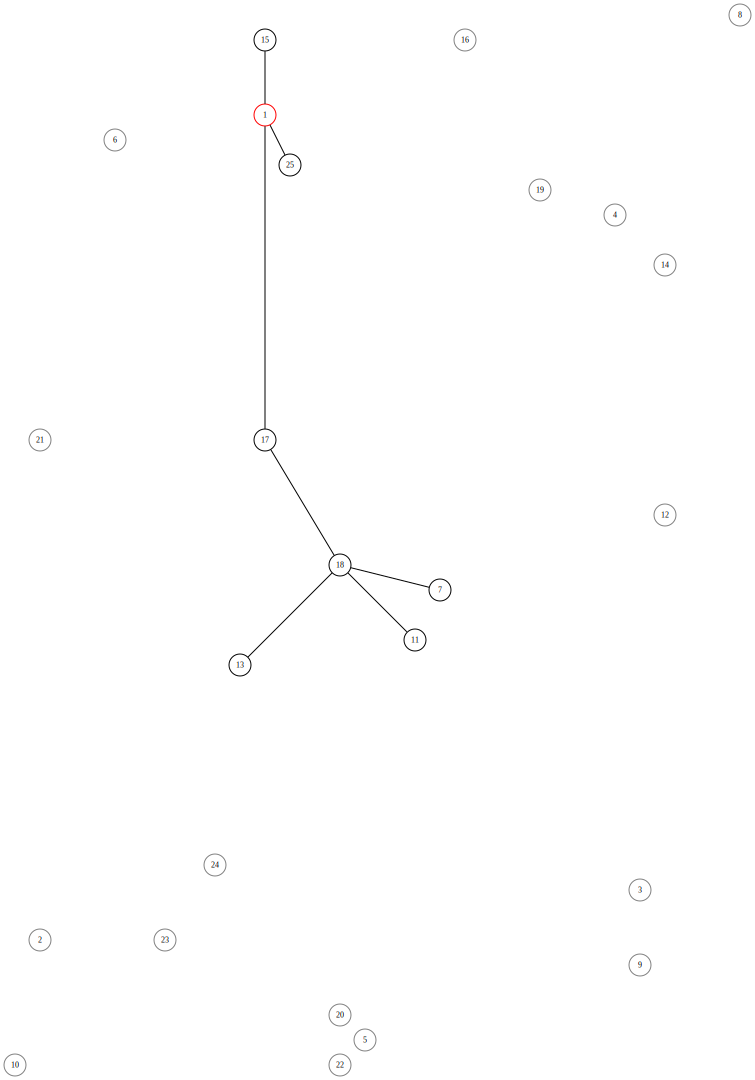

In [32]:
DrawSol(x)
display(SVG(filename=basename+'_pcst_sol.svg'))


